In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["WANDB_SILENT"] = 'True'

In [29]:
import warnings
warnings.filterwarnings('ignore')
import random
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread as gif_imread
from catalyst import utils
import cv2
import glob
from PIL import Image
import os.path as osp
from tqdm import tqdm
from typing import Callable, List, Tuple
import torch
import catalyst
import wandb

In [5]:
def examples(image_path = '../input/uavid-semantic-segmentation-dataset/valid/valid/seq19/Images/000300.png', mask_path ='./validlabels/seq19/TrainId/000300.png'):
    image = Image.open(image_path)
    mask = Image.open(mask_path)    
    plt.figure(figsize=(14, 20))
    plt.subplot(1, 2, 1)
    plt.imshow(image)

    plt.subplot(1, 2, 2)
    plt.imshow(mask)

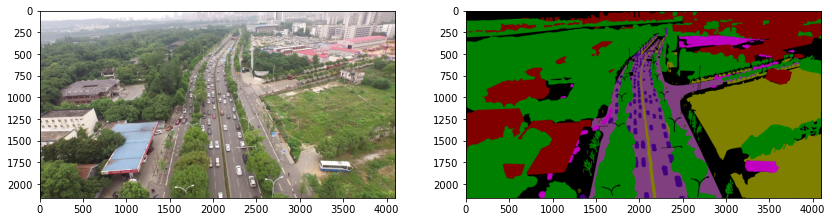

In [6]:
image_path = '../input/uavid-semantic-segmentation-dataset/train/train/seq12/Images/000100.png'
mask_path = '../input/uavid-semantic-segmentation-dataset/train/train/seq12/Labels/000100.png'
examples(image_path, mask_path)

In [7]:
class UAVidColorTransformer:
    def __init__(self):
    # color table.
        self.clr_tab = self.createColorTable()
    # id table.
        id_tab = {}
        for k, v in self.clr_tab.items():
            id_tab[k] = self.clr2id(v)
        self.id_tab = id_tab

    def createColorTable(self):
        clr_tab = {}
        clr_tab['Clutter'] = [0, 0, 0]
        clr_tab['Building'] = [128, 0, 0]
        clr_tab['Road'] = [128, 64, 128]
        clr_tab['Static_Car'] = [192, 0, 192]
        clr_tab['Tree'] = [0, 128, 0]
        clr_tab['Vegetation'] = [128, 128, 0]
        clr_tab['Human'] = [64, 64, 0]
        clr_tab['Moving_Car'] = [64, 0, 128]
        return clr_tab

    def colorTable(self):
        return self.clr_tab
   
    def clr2id(self, clr):
        return clr[0]+clr[1]*255+clr[2]*255*255

  #transform to uint8 integer label
    def transform(self,label, dtype=np.int32):
        height,width = label.shape[:2]
    # default value is index of clutter.
        newLabel = np.zeros((height, width), dtype=dtype)
        id_label = label.astype(np.int64)
        id_label = id_label[:,:,0]+id_label[:,:,1]*255+id_label[:,:,2]*255*255
        for tid,val in enumerate(self.id_tab.values()):
            mask = (id_label == val)
            newLabel[mask] = tid
        return newLabel

  #transform back to 3 channels uint8 label
    def inverse_transform(self, label):
        label_img = np.zeros(shape=(label.shape[0], label.shape[1],3),dtype=np.uint8)
        values = list(self.clr_tab.values())
        for tid,val in enumerate(values):
            mask = (label==tid)
            label_img[mask] = val
        return label_img

In [8]:
clrEnc = UAVidColorTransformer()
def prepareTrainIDForDir(gtDirPath, saveDirPath):
    gt_paths = [p for p in os.listdir(gtDirPath) if p.startswith('seq')]
    for pd in tqdm(gt_paths):
        lbl_dir = osp.join(gtDirPath, pd, 'Labels')
        lbl_paths = os.listdir(lbl_dir)
        if not osp.isdir(osp.join(saveDirPath, pd, 'TrainId')):
            os.makedirs(osp.join(saveDirPath, pd, 'TrainId'))
            assert osp.isdir(osp.join(saveDirPath, pd, 'TrainId')), 'Fail to create directory:%s'%(osp.join(saveDirPath, pd, 'TrainId'))
        for lbl_p in lbl_paths:
            lbl_path = osp.abspath(osp.join(lbl_dir, lbl_p))
            trainId_path = osp.join(saveDirPath, pd, 'TrainId', lbl_p)
            gt = np.array(Image.open(lbl_path))
            trainId = clrEnc.transform(gt, dtype=np.uint8)
            Image.fromarray(trainId).save(trainId_path)

In [9]:
prepareTrainIDForDir('../input/uavid-semantic-segmentation-dataset/train/train', './trainlabels/')
prepareTrainIDForDir('../input/uavid-semantic-segmentation-dataset/valid/valid', './validlabels/')

100%|██████████| 7/7 [00:40<00:00,  5.83s/it]


In [10]:
train_image_list = sorted(glob.glob(pathname='../input/uavid-semantic-segmentation-dataset/train/train/*/Images/*.png', recursive=True))
train_mask_list =  sorted(glob.glob(pathname='./trainlabels/*/TrainId/*.png', recursive=True))

In [11]:
valid_image_list = sorted(glob.glob(pathname='../input/uavid-semantic-segmentation-dataset/valid/valid/*/Images/*.png', recursive=True))
valid_mask_list =  sorted(glob.glob(pathname='./validlabels/*/TrainId/*.png', recursive=True))

In [12]:
print(train_image_list[42])
print(train_mask_list[42])

../input/uavid-semantic-segmentation-dataset/train/train/seq13/Images/000200.png
./trainlabels/seq13/TrainId/000200.png


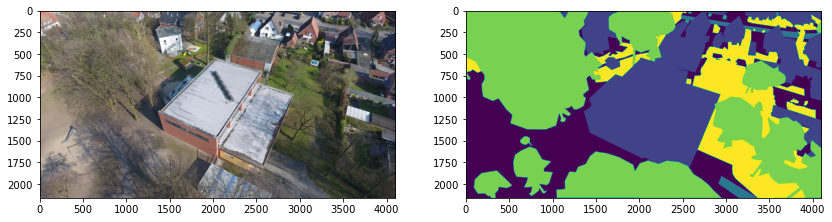

In [13]:
examples()

In [14]:
wandb.login(key='44b74d6614becfad4329893ea0144da65336bdbd')

SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)
is_fp16_used = True

In [15]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """

    CLASSES = ['clutter', 'building', 'road', 'static_car', 'tree', 'vegetation', 'human', 'moving_car']
    
    def __init__(
            self, 
            images_list, 
            masks_list, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.images_list = images_list
        self.masks_list = masks_list
        self.classes = classes
        
        # convert str names to class values on masks
        if self.classes is not None:
            self.class_values = np.array([self.CLASSES.index(cls.lower()) for cls in classes]) / 255
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_list[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_list[i], 0)
        mask = mask.astype('float') / 255
        
        # extract certain classes from mask (e.g. cars)
        if self.classes is not None:
            masks = [(mask == v) for v in self.class_values]
            mask = np.stack(masks, axis=-1).astype('float')
        else:
            mask = np.expand_dims(mask, 2)
#        result = {'image': image, 'mask': mask}
        # apply augmentations
        if self.augmentation:
#            result = self.augmentation(**result)
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        
        # apply preprocessing
        if self.preprocessing:
#            result = self.preprocessing(**result)
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
#        return result
        return image, mask
#        return {'image': image, 'mask': mask}
        
    def __len__(self):
        return len(self.images_list)


In [90]:
# helper function for data visualization
def visualize(image, mask, label=None, truth=None, augment=False):
    if truth is None:
        plt.figure(figsize=(14, 20))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        if augment == False:
            plt.title(f"{'Original Image'}")
        else:
            plt.title(f"{'Augmented Image'}")

        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        if label is not None:
            plt.title(f"{label.capitalize()}")
        
    else:
        plt.figure(figsize=(20, 30))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title(f"{'Original Image'}")

        plt.subplot(1, 3, 2)
        plt.imshow(mask)
        plt.title(f"{'Prediction'}")
        
        plt.subplot(1, 3, 3)
        plt.imshow(truth)
        plt.title(f"{'Ground Truth'}")

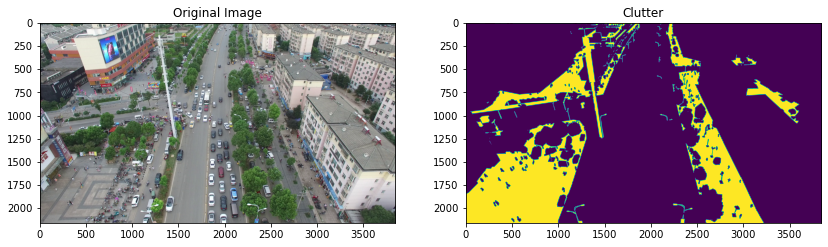

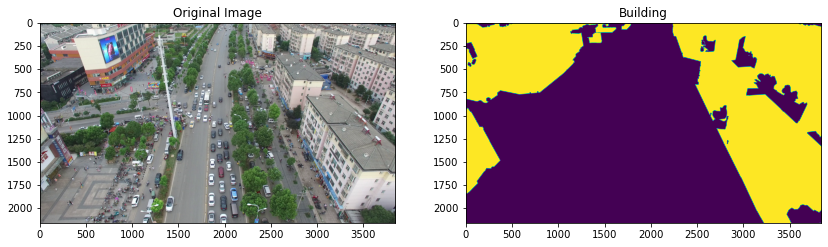

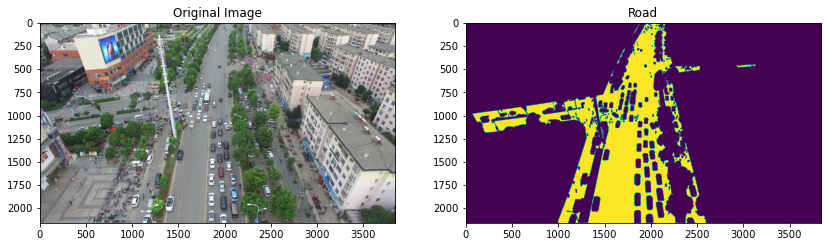

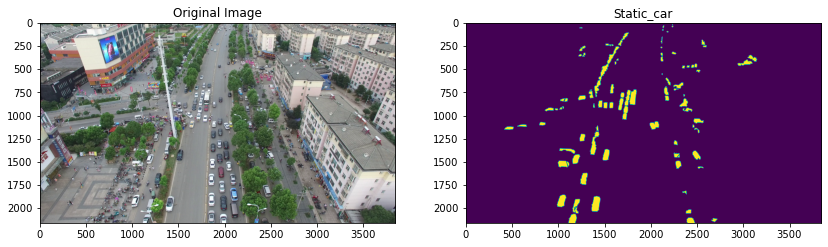

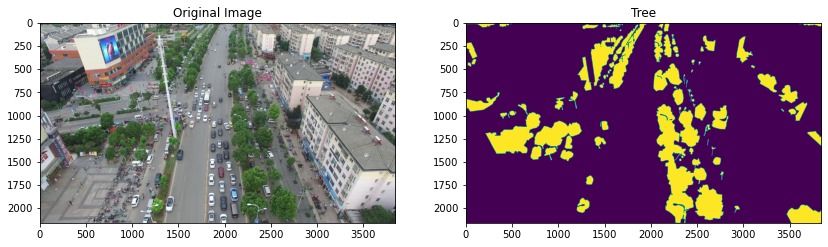

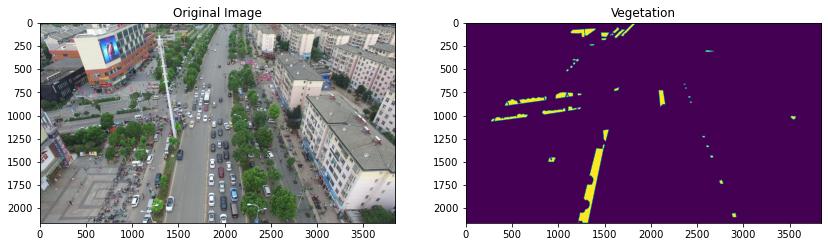

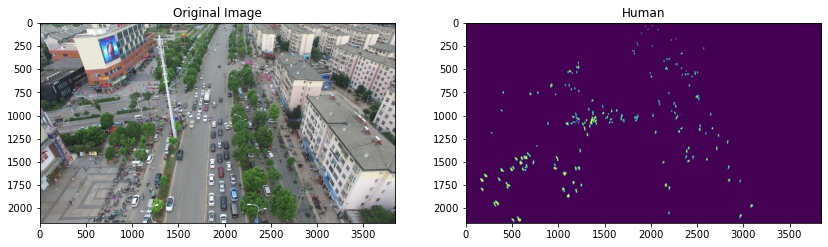

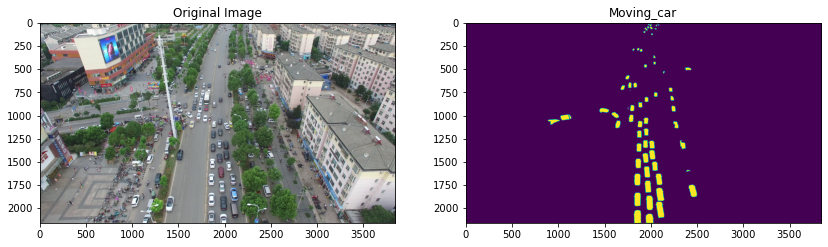

In [17]:
labels = ['clutter', 'building', 'road', 'static_car', 'tree', 'vegetation', 'human', 'moving_car']
for label in labels:
    dataset = Dataset(train_image_list, train_mask_list, classes=[label])

    image, mask = dataset[4]
    visualize(
        image=image, mask=mask.squeeze(),
        label = label)

In [18]:
import albumentations as albu
#from albumentations.pytorch import ToTensorV2, ToTensor

def get_training_augmentation():
    train_transform = [

        albu.Resize(576, 1024, p=1),
#        albu.PadIfNeeded(1024, 1024, always_apply=True),
        albu.HorizontalFlip(p=0.5),

        albu.OneOf([
            albu.RandomBrightnessContrast(
                  brightness_limit=0.4, contrast_limit=0.4, p=1),
            albu.CLAHE(p=1),
            albu.HueSaturationValue(p=1)
            ],
            p=0.9,
        ),

        albu.IAAAdditiveGaussianNoise(p=0.2),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [albu.Resize(576, 1024, p=1),
#                      albu.PadIfNeeded(1024, 1024, always_apply=True)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    #return torch.from_numpy(img.transpose(2, 0, 1))
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
#         albu.ToTensorV2()
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

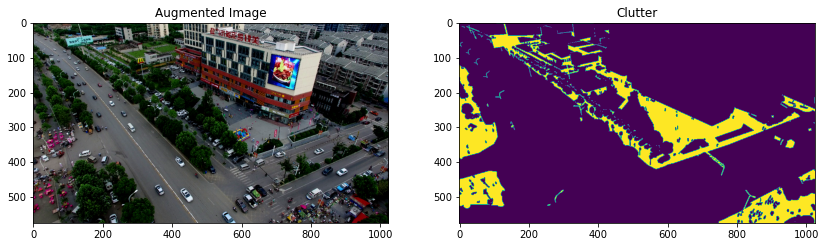

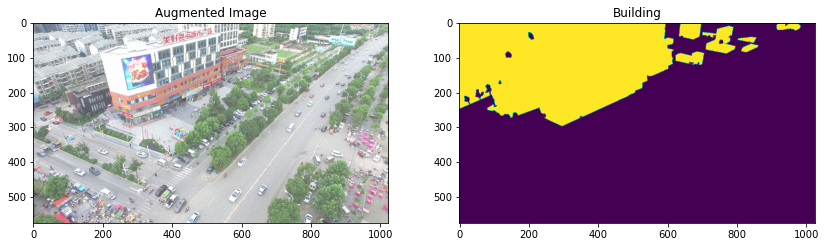

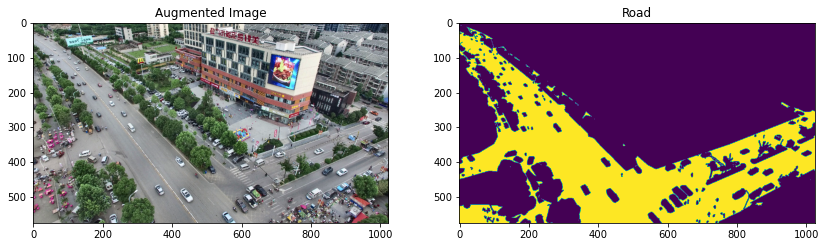

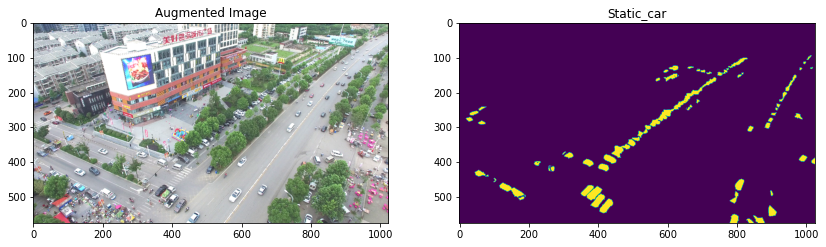

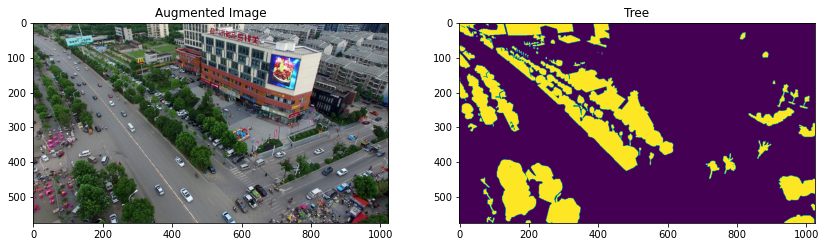

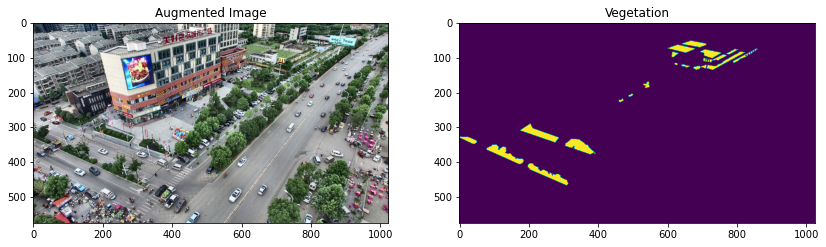

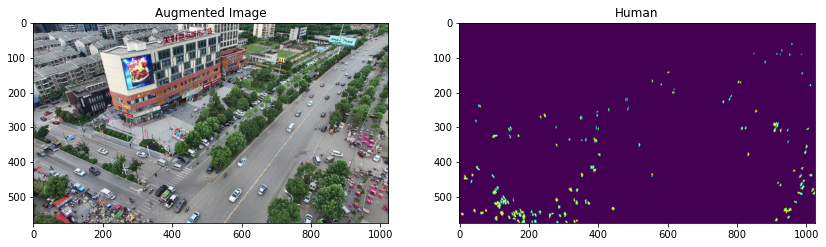

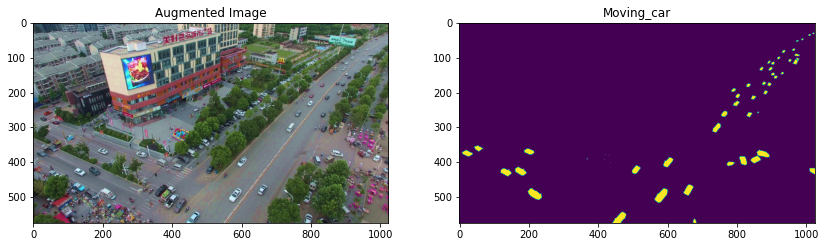

In [19]:
#### Visualize resulted augmented images and masks
labels = ['clutter', 'building', 'road', 'static_car', 'tree', 'vegetation', 'human', 'moving_car']
for label in labels:
    augmented_dataset = Dataset(
        train_image_list, 
        train_mask_list, 
        augmentation=get_training_augmentation(), 
        classes=[label],
    )

# same image with different random transforms
    image, mask = augmented_dataset[8]
    visualize(
        image=image, mask=mask.squeeze(),
        label = label, augment=True)

In [ ]:
augmented_dataset = Dataset(
        train_image_list, 
        train_mask_list, 
        augmentation=get_training_augmentation(), 
        classes=['tree'],
    )

# same image with different random transforms
image, mask = augmented_dataset[4]#['image'], augmented_dataset[4]['mask']

print(image.shape)
print(mask.shape)

In [1]:
!pip install segmentation-models-pytorch ttach
!pip install --pre torch==1.7.0.dev20200701+cu101 torchvision==0.8.0.dev20200701+cu101 -f https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html

     |████████████████████████████████| 42 kB 548 kB/s eta 0:00:01
     |████████████████████████████████| 58 kB 3.8 MB/s eta 0:00:011
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=2a7ef8f6dfe6d7071f0f5c718665c8d4cbbc9075d92a64ef27a010c50228d168
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=f972a2445505e78d170f57111d05bdabfa8eee38f68b893af378d601461f3ab3
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
Successfully built pretrainedmodels efficientnet-pytorch
Looking in links: https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html
     |████████████████████████████████| 844.4 MB 12 kB/s s eta 0:00:01          | 136.6 MB 53.6 MB/s eta 0:00:14     |██████                          | 158.0 MB 4

In [31]:
import segmentation_models_pytorch as smp

ENCODER = 'efficientnet-b3'#'resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
CLASSES = ['clutter', 'building', 'road', 'static_car', 'tree', 'vegetation', 'human', 'moving_car']
DEVICE = 'cuda'
#AUX_PARAMS = dict(
#    pooling='avg',             # one of 'avg', 'max'
#    dropout=0.2,               # dropout ratio, default is None
#    classes=8,                 # define number of output labels
#)

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), #8
    activation=ACTIVATION,
#    aux_params=AUX_PARAMS,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [32]:
batch_size = 6

train_dataset = Dataset(
    train_image_list, 
    train_mask_list, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    valid_image_list, 
    valid_mask_list, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

loaders = {
    "train": train_loader,
    "valid": valid_loader
}

In [20]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [21]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [22]:
max_score = 0

for i in range(0, 15):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 12/12 [00:21<00:00,  1.76s/it, dice_loss - 0.3045, iou_score - 0.5422]
Model saved!

Epoch: 1
valid: 100%|██████████| 12/12 [00:19<00:00,  1.61s/it, dice_loss - 0.2444, iou_score - 0.6248]
Model saved!

Epoch: 2
train:  82%|████████▏ | 28/34 [00:52<00:11,  1.88s/it, dice_loss - 0.1965, iou_score - 0.6822]


KeyboardInterrupt: 

In [33]:
if is_fp16_used:
    fp16_params = dict(opt_level="O1") # params for FP16
else:
    fp16_params = None

print(f"FP16 params: {fp16_params}")

FP16 params: {'opt_level': 'O1'}


In [34]:
from catalyst.contrib.nn import BCEDiceLoss, RAdam, Lookahead
from catalyst.dl import SupervisedRunner
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

logdir = "./logs"
num_epochs = 30
base_optimizer = RAdam([
    {'params': model.decoder.parameters(), 'lr': 1e-3, 'weight_decay': 3e-4}, 
    {'params': model.encoder.parameters(), 'lr': 1e-4, 'weight_decay': 3e-5},
    {'params': model.segmentation_head.parameters(), 'lr': 1e-3},
])
optimizer = Lookahead(base_optimizer)
scheduler = ReduceLROnPlateau(optimizer, factor=0.3, patience=2, mode='max')
criterion = BCEDiceLoss(activation=None)
runner = SupervisedRunner()

In [35]:
params = {
    'encoder_lr': 1e-4,
    'decoder_lr': 1e-3,
    'segmentation_head_lr': 1e-3,
    'num_epochs': 20,
    'factor': 0.3,
    'lr_patience': 2,
    'fp_used': True,
    'batch_size': 6,
    'backbone': 'efficientnet-b3',
    'decoder': 'FPN'
}

In [38]:
from catalyst.dl.callbacks import DiceCallback, IouCallback, \
  CriterionCallback, MetricAggregationCallback, WandbLogger, EarlyStoppingCallback#, OptimizerCallback, SchedulerCallback

callbacks = [

    # metrics
    DiceCallback(),
    IouCallback(),
    
    #OptimizerCallback(accumulation_steps=2),
    EarlyStoppingCallback(patience=5, metric='iou', minimize=False),
    WandbLogger(project='X', name='18'),
    
]

In [39]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    # our dataloaders
    loaders=loaders,
    # We can specify the callbacks list for the experiment;
    callbacks=callbacks,
    # path to save logs
    logdir=logdir,
    num_epochs=num_epochs,
    # save our best checkpoint by IoU metric
    main_metric="iou",
    # IoU needs to be maximized.
    minimize_metric=False,
    # for FP16. It uses the variable from the very first cell
    fp16=fp16_params,
    # prints train logs
    verbose=True,
)

1/30 * Epoch (train): 100% 33/33 [02:25<00:00,  4.40s/it, dice=0.232, iou=0.131, loss=0.647]
1/30 * Epoch (valid): 100% 12/12 [00:51<00:00,  4.28s/it, dice=0.230, iou=0.130, loss=0.657]
[2020-07-27 22:40:23,864] 
1/30 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/30 * Epoch 1 (train): dice=0.2202 | iou=0.1237 | loss=0.7546
1/30 * Epoch 1 (valid): dice=0.2399 | iou=0.1363 | loss=0.6008
2/30 * Epoch (train): 100% 33/33 [02:23<00:00,  4.36s/it, dice=0.250, iou=0.143, loss=0.514]
2/30 * Epoch (valid): 100% 12/12 [00:48<00:00,  4.06s/it, dice=0.240, iou=0.136, loss=0.574]
[2020-07-27 22:43:37,728] 
2/30 * Epoch 2 (_base): lr=0.0010 | momentum=0.9000
2/30 * Epoch 2 (train): dice=0.2425 | iou=0.1380 | loss=0.5680
2/30 * Epoch 2 (valid): dice=0.2493 | iou=0.1424 | loss=0.5145
3/30 * Epoch (train): 100% 33/33 [02:21<00:00,  4.30s/it, dice=0.254, iou=0.145, loss=0.493]
3/30 * Epoch (valid): 100% 12/12 [00:48<00:00,  4.08s/it, dice=0.250, iou=0.143, loss=0.516]
[2020-07-27 22:46:50,011] 
3/30 

22/30 * Epoch (train): 100% 33/33 [02:21<00:00,  4.29s/it, dice=0.266, iou=0.153, loss=0.402]
22/30 * Epoch (valid): 100% 12/12 [00:47<00:00,  3.95s/it, dice=0.262, iou=0.151, loss=0.425]
[2020-07-27 23:47:17,518] 
22/30 * Epoch 22 (_base): lr=0.0010 | momentum=0.9000
22/30 * Epoch 22 (train): dice=0.2671 | iou=0.1542 | loss=0.3957
22/30 * Epoch 22 (valid): dice=0.2641 | iou=0.1522 | loss=0.4128
23/30 * Epoch (train): 100% 33/33 [02:19<00:00,  4.23s/it, dice=0.268, iou=0.155, loss=0.391]
23/30 * Epoch (valid): 100% 12/12 [00:47<00:00,  3.99s/it, dice=0.262, iou=0.151, loss=0.427]
[2020-07-27 23:50:26,358] 
23/30 * Epoch 23 (_base): lr=0.0003 | momentum=0.9000
23/30 * Epoch 23 (train): dice=0.2675 | iou=0.1544 | loss=0.3931
23/30 * Epoch 23 (valid): dice=0.2640 | iou=0.1521 | loss=0.4147
24/30 * Epoch (train): 100% 33/33 [02:21<00:00,  4.28s/it, dice=0.267, iou=0.154, loss=0.397]
24/30 * Epoch (valid): 100% 12/12 [00:47<00:00,  3.98s/it, dice=0.263, iou=0.151, loss=0.424]
[2020-07-27 23

## Inference

In [40]:
!cp logs/checkpoints/train.25.pth ./
wandb.save('./train.25.pth')

['logs/wandb/run-20200727_223706-3717vekf/train.25.pth']

In [ ]:
from catalyst.dl.utils import trace_model_from_checkpoint, trace

mod = trace.load_checkpoint('./train.3.pth')
model.load_state_dict(mod.get('model_state_dict'))

In [41]:
batch = next(iter(loaders['valid']))
batch

[tensor([[[[-0.0629, -0.1999, -0.5082,  ..., -1.1075,  0.1597,  0.7933],
           [-0.1657, -0.3369, -0.5424,  ..., -0.5596,  0.4851,  1.0159],
           [ 0.2111,  0.0741,  0.0056,  ..., -0.1143,  0.7591,  1.1700],
           ...,
           [-1.0390, -1.3473, -1.2788,  ...,  1.0331,  1.0502,  0.9988],
           [-1.1075, -1.5185, -1.3473,  ...,  1.1358,  1.0844,  1.0673],
           [-1.2274, -1.5185, -1.6213,  ...,  1.1358,  1.1015,  1.0673]],
 
          [[ 0.2052,  0.0651, -0.2500,  ..., -0.7752,  0.4328,  0.9580],
           [ 0.1001, -0.0749, -0.2850,  ..., -0.2150,  0.7654,  1.2031],
           [ 0.4853,  0.3452,  0.2752,  ...,  0.2577,  1.0630,  1.3256],
           ...,
           [-0.6001, -0.9153, -0.8452,  ...,  1.4307,  1.4132,  1.3606],
           [-0.6702, -1.0903, -0.9153,  ...,  1.5007,  1.4132,  1.3957],
           [-0.8102, -1.0903, -1.1954,  ...,  1.5357,  1.4307,  1.3957]],
 
          [[ 0.2522,  0.1128, -0.2010,  ..., -0.5670,  0.4962,  0.9668],
           [ 

In [31]:
print(batch[0][0].shape, batch[1].shape)

torch.Size([3, 576, 1024]) torch.Size([8, 576, 1024])


In [42]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [43]:
model.eval()
masks_batch = model(to_device(batch[0], torch.device('cuda')))

In [76]:
images = [utils.tensor_to_ndimage(batch[0][i]) for i in range(6)]
class_masks = [np.transpose(masks_batch[i].cpu().detach().numpy(),(1,2,0)) for i in range(6)]
truth = [np.transpose(batch[1][0].cpu().detach().numpy(),(1,2,0)) for i in range(6)]
masks = [class_masks[j][:,:,i] for i in range(8) for j in range(6)]

In [113]:
#print(masks1[0].shape)
masks[0].shape

(576, 1024)

In [118]:
#masks1 = [image_mask[:,:,i] for i in range(8)]
masks2 = [image_mask1[:,:,i] for i in range(8)]
#truth1 = [truth[:,:,i] for i in range(8)].shape

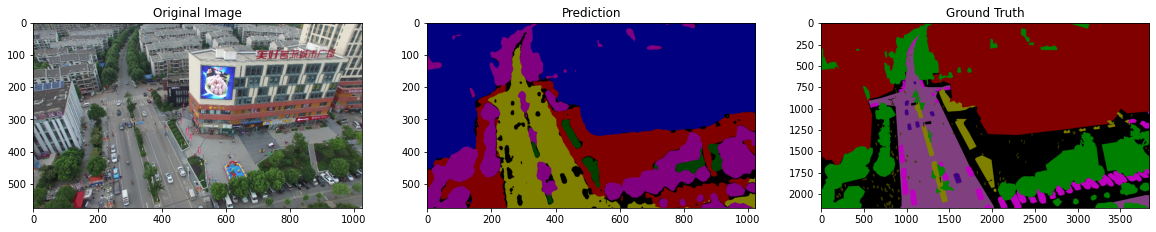

In [93]:
over = mask_to_overlay_image(image=images[0], masks=masks1, threshold=0.4)
#gr = Image.open('../input/uavid-semantic-segmentation-dataset/valid/valid/seq16/Labels/000000.png')
visualize(images[0], over, truth=gr)

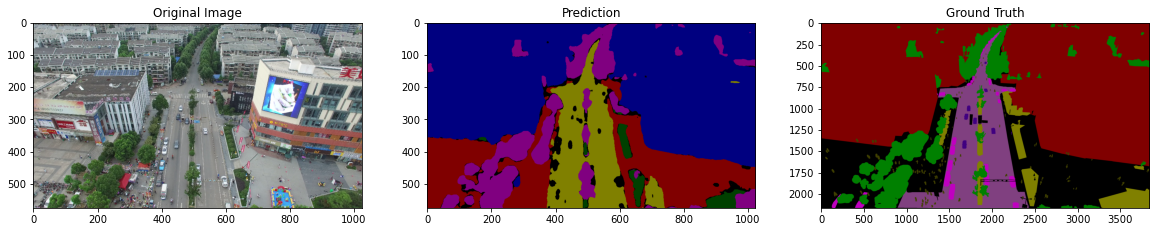

In [121]:
over = mask_to_overlay_image(image=images[1], masks=masks2, threshold=0.4)
gr1 = Image.open('../input/uavid-semantic-segmentation-dataset/valid/valid/seq16/Labels/000100.png')
visualize(images[1], over, truth=gr1)

In [ ]:
plt.figure(figsize=(14,20))
plt.imshow(over)

In [105]:
color_list = [[0, 0, 0], [128, 0, 0], [128, 64, 128], [192, 0, 192], [0, 128, 0], [128, 128, 0], [64, 64, 0], [64, 0, 128]]

from skimage.color import label2rgb
from typing import List, Tuple, Union

def mask_to_overlay_image_v2(
    image: np.ndarray,
    masks: List[np.ndarray],
    threshold: float = 0,
    mask_strength: float = 0.5,
) -> np.ndarray:
    """Draws every mask for with some color over image.

    Args:
        image (np.ndarray): RGB image used as underlay for masks
        masks (List[np.ndarray]): list of masks
        threshold (float): threshold for masks binarization
        mask_strength (float): opacity of colorized masks

    Returns:
        np.ndarray: HxWx3 image with overlay
    """
    h, w = image.shape[:2]
    labels = np.zeros((h, w), np.uint8)

    for idx, mask in enumerate(masks, start=0):
        labels[mask > threshold] = idx

    mask = label2rgb(labels, bg_color=0)

    image = np.array(image) / 255.0
    image_with_overlay = image * (1 - mask_strength) + mask * mask_strength
    image_with_overlay = (
        (image_with_overlay * 255).clip(0, 255).round().astype(np.uint8)
    )

    return image_with_overlay

In [32]:
image = utils.tensor_to_ndimage(batch[0][0])
print(image.shape)

(576, 1024, 3)


In [37]:
model.eval()
masks_batch = model(to_device(batch[0], torch.device('cuda')))
print(masks_batch.shape)

In [117]:
image_mask1 = np.transpose(masks_batch[1].cpu().detach().numpy(),(1,2,0))
image_mask1.shape

(576, 1024, 8)

In [39]:
masks = [image_mask[:,:,i] for i in range(8)]
masks

[array([[4.3631259e-02, 3.0935366e-02, 2.1849338e-02, ..., 7.7503715e-03,
         1.1379113e-02, 1.6678290e-02],
        [2.6993047e-02, 1.8373022e-02, 1.2470454e-02, ..., 4.8558111e-03,
         7.9572024e-03, 1.3013543e-02],
        [1.6589537e-02, 1.0854898e-02, 7.0883054e-03, ..., 3.0389819e-03,
         5.5585373e-03, 1.0145743e-02],
        ...,
        [1.4824413e-06, 8.1436070e-07, 4.4735873e-07, ..., 1.0465767e-02,
         1.6445631e-02, 2.5753332e-02],
        [3.8363423e-06, 2.2201261e-06, 1.2848062e-06, ..., 8.8960081e-03,
         1.4180010e-02, 2.2531217e-02],
        [9.9272802e-06, 6.0521670e-06, 3.6896952e-06, ..., 7.5599775e-03,
         1.2222735e-02, 1.9704249e-02]], dtype=float32),
 array([[9.26145136e-01, 9.53001857e-01, 9.70404327e-01, ...,
         9.79506135e-01, 9.67894137e-01, 9.50038493e-01],
        [9.59589422e-01, 9.75398540e-01, 9.85118806e-01, ...,
         9.86926198e-01, 9.79055583e-01, 9.66607332e-01],
        [9.78244603e-01, 9.87264872e-01, 9.925

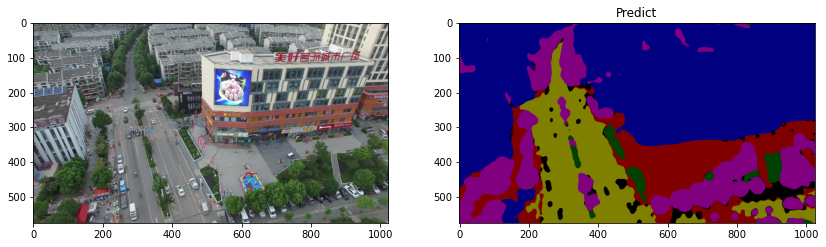

In [44]:
from catalyst.utils import mask_to_overlay_image
over = mask_to_overlay_image(image=image, masks=masks, threshold=0.1)
over.shape
visualize(image, over, 'predict')

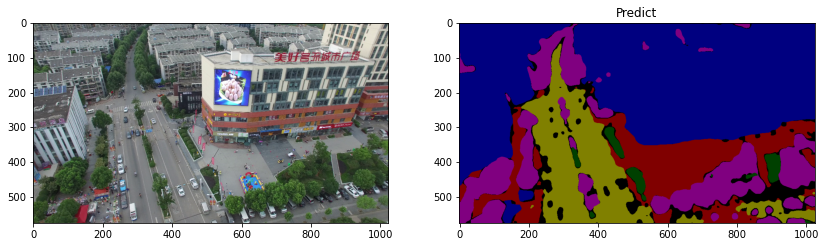

In [42]:
over = mask_to_overlay_image(image=image, masks=masks, threshold=0.5)
over.shape
visualize(image, over, 'predict')

In [21]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=[DiceCallback(), EarlyStoppingCallback(patience=5, min_delta=0.001)],
    num_epochs=num_epochs,
    verbose=True
)

1/10 * Epoch (train): 100% 34/34 [00:58<00:00,  1.73s/it, dice=0.015, loss=0.985]
1/10 * Epoch (valid): 100% 12/12 [00:19<00:00,  1.61s/it, dice=0.023, loss=0.978]
[2020-07-27 18:03:28,167] 
1/10 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/10 * Epoch 1 (train): dice=0.0183 | loss=0.9818
1/10 * Epoch 1 (valid): dice=0.0179 | loss=0.9823
2/10 * Epoch (train): 100% 34/34 [00:55<00:00,  1.63s/it, dice=0.020, loss=0.980]
2/10 * Epoch (valid): 100% 12/12 [00:18<00:00,  1.54s/it, dice=0.023, loss=0.978]
[2020-07-27 18:04:42,139] 
2/10 * Epoch 2 (_base): lr=0.0010 | momentum=0.9000
2/10 * Epoch 2 (train): dice=0.0183 | loss=0.9818
2/10 * Epoch 2 (valid): dice=0.0179 | loss=0.9823
3/10 * Epoch (train): 100% 34/34 [00:54<00:00,  1.61s/it, dice=0.015, loss=0.985]
3/10 * Epoch (valid): 100% 12/12 [00:17<00:00,  1.45s/it, dice=0.023, loss=0.978]
[2020-07-27 18:05:54,312] 
3/10 * Epoch 3 (_base): lr=0.0010 | momentum=0.9000
3/10 * Epoch 3 (train): dice=0.0183 | loss=0.9818
3/10 * Epoch 3 (valid

In [25]:
import gc
torch.cuda.empty_cache()
gc.collect()

40

In [ ]:
batch = next(iter(train_loader))
batch

In [ ]:
#batch[0][0].shape
batch[1][0].shape

In [ ]:
model.eval()
mas = model(to_device(batch[0], torch.device('cuda')))

In [ ]:
image = utils.tensor_to_ndimage(batch[0][4])
mask = batch[1][4]
image_mask = np.transpose(mask.cpu().detach().numpy(),(1,2,0))
image_mask.shape

In [ ]:
print(image.shape)
print(mask.shape)

In [ ]:
visualize(image, image_mask.squeeze(), label='mask')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
model.eval()
mas = model(to_device(batch[0], torch.device('cuda')))

In [ ]:
mas[0].shape

In [ ]:
image_mask = np.transpose(mas[0].cpu().detach().numpy(),(1,2,0))
image_mask.shape

In [ ]:
masks = [image_mask[:,:,i] for i in range(8)]
masks

In [ ]:
from catalyst.utils import mask_to_overlay_image
over = mask_to_overlay_image(image=image, masks=masks, threshold=0.001)
over.shape
visualize(image, over, 'predict')

In [ ]:
mask = mas[0]
mas[0].shape
import numpy as np
image_mask = np.transpose(mas[0].cpu().detach().numpy(),(1,2,0))
image_mask.shape
masks = [image_mask[:,:,i] for i in range(20)]
masks
from catalyst.utils import mask_to_overlay_image
over = mask_to_overlay_image(image=image, masks=masks, threshold=0.001)
over.shape
show_examples('', image, over)

In [ ]:
valid_dataset[0][1].shape

In [ ]:
next(iter(loaders['train']))

In [ ]:
result = {}
result['image'] = train_dataset[0][0]
result['mask'] = train_dataset[0][1]

In [ ]:
from torch import nn

from catalyst.contrib.nn import DiceLoss, IoULoss#, LovaszLossMultiClass

# we have multiple criterions
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss()
    #'lov': LovaszLossMultiClass()
    #"foc": FocalLossMultiClass()
}

In [ ]:
from catalyst.dl import SupervisedRunner

num_epochs = 15
logdir = "."

device = utils.get_device()
print(f"device: {device}")

is_fp16_used = False
if is_fp16_used:
    fp16_params = dict(opt_level="O1") # params for FP16
else:
    fp16_params = None

print(f"FP16 params: {fp16_params}")


# by default SupervisedRunner uses "features" and "targets",
# in our case we get "image" and "mask" keys in dataset __getitem__
runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

In [ ]:
from torch import optim

from catalyst.contrib.nn import RAdam, Lookahead, OneCycleLRWithWarmup

learning_rate = 0.001
encoder_learning_rate = 0.0005

#base_optimizer = RAdam([
#    {'params': model.decoder.parameters(), 'lr': 1e-3}, 
#    {'params': model.encoder.parameters(), 'lr': 5e-4},  
#])

# Since we use a pre-trained encoder, we will reduce the learning rate on it.
layerwise_params = {"encoder*": dict(lr=encoder_learning_rate)}#, weight_decay=0.00003)}

# This function removes weight_decay for biases and applies our layerwise_params
model_params = utils.process_model_params(model, layerwise_params=layerwise_params)

# Catalyst has new SOTA optimizers out of box
base_optimizer = RAdam(model_params, lr=learning_rate)#, weight_decay=0.0003)
optimizer = Lookahead(base_optimizer)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.4, patience=2, mode='max')
#scheduler = OneCycleLRWithWarmup(
#    optimizer, 
#    num_steps=num_epochs, 
#    lr_range=(0.002, 0.00001),
#    init_lr = learning_rate,
#    warmup_steps=2
#)

In [ ]:
from catalyst.dl.callbacks import DiceCallback, IouCallback, \
  CriterionCallback, MetricAggregationCallback, WandbLogger#, OptimizerCallback

callbacks = [
    # Each criterion is calculated separately.
    CriterionCallback(
        input_key="mask",
        prefix="loss_dice",
        criterion_key="dice"
    ),
    CriterionCallback(
        input_key="mask",
        prefix='loss_iou',
        criterion_key="iou"
    ),
    #CriterionCallback(
    #    input_key="mask",
    #    prefix='loss_lov',
    #    criterion_key='lov'
    #),

    # And only then we aggregate everything into one loss.
    MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum", # can be "sum", "weighted_sum" or "mean"
        # because we want weighted sum, we need to add scale for each loss
        metrics={"loss_dice": 1.0, "loss_iou": 1.0},#, 'loss_lov':1.0},#, "loss_foc": 0.8},
    ),

    # metrics
    DiceCallback(input_key="mask"),
    IouCallback(input_key="mask"),
    
    #OptimizerCallback(accumulation_steps=2),
    
    WandbLogger(project='X', name='13')
]


runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    # our dataloaders
    loaders=loaders,
    # We can specify the callbacks list for the experiment;
    callbacks=callbacks,
    # path to save logs
    logdir=logdir,
    num_epochs=num_epochs,
    # save our best checkpoint by IoU metric
    main_metric="iou",
    # IoU needs to be maximized.
    minimize_metric=False,
    # for FP16. It uses the variable from the very first cell
    fp16=fp16_params,
    # prints train logs
    verbose=True,
)

In [ ]:
names = [os.path.join(file_list[i].split('/')[5],file_list[i].split('/')[7]) for i in range(200)]
names

In [ ]:
label_names = [os.path.join(label_list[i].split('/')[2],label_list[i].split('/')[4]) for i in range(200)]
label_names

In [ ]:
sorted_images = sorted(names)
sorted_images

In [ ]:
sorted_masks = sorted(label_names)
sorted_masks

In [ ]:
#../input/uavid-semantic-segmentation-dataset/train/train/seq13/Images/000000.png
#./trainlabels/seq13/TrainId/000600.png
#a, b = sorted_images[0].split('/')
#print(a,b)
images_path = [f'../input/uavid-semantic-segmentation-dataset/train/train/{a}/Images/{b}' for a,b in [sorted_images[i].split('/') for i in range(200)]]

In [ ]:
masks_path = [f'./trainlabels/{a}/TrainId/{b}' for a,b in [sorted_masks[i].split('/') for i in range(200)]]

In [ ]:
print(masks_path[21])
print(images_path[21])

In [ ]:
prepareTrainIDForDir('../input/uavid-semantic-segmentation-dataset/train/train', './trainlabels/')

In [ ]:
prepareTrainIDForDir('../input/uavid-semantic-segmentation-dataset/valid/valid', './validlabels/')

In [26]:
import wandb
wandb.login(key='44b74d6614becfad4329893ea0144da65336bdbd')

is_fp16_used = True

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: WARNING Calling wandb.login() without arguments from jupyter should prompt you for an api key.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
from typing import Callable, List, Tuple

import os
import torch
import catalyst

from catalyst.dl import utils

print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # "" - CPU, "0" - 1 GPU, "0,1" - MultiGPU

SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

In [ ]:
from pathlib import Path

ROOT = Path("../input/semantic-drone-dataset/semantic_drone_dataset/")

train_image_path = ROOT / "original_images"
train_mask_path = ROOT / "label_images_semantic"

ALL_IMAGES = sorted(train_image_path.glob("*.jpg"))
len(ALL_IMAGES)

ALL_MASKS = sorted(train_mask_path.glob("*.png"))
len(ALL_MASKS)

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['tree', 'gras', 'other_vegetation', 'dirt', 'gravel', 'rocks', 'water', 'paved_area', 'pool', 'person', 'dog', 'car', 
               'bicycle', 'roof', 'wall', 'fence', 'fence-pole', 'window', 'door', 'obstacle']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.ids2 = os.listdir(masks_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids2]
        
        # convert str names to class values on masks
        self.class_values = self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return {'image': image, 'mask': mask}
        
    def __len__(self):
        return len(self.ids)

In [ ]:
            #result['image'] = result['image'].float()
            result['mask'] = result['mask'].unsqueeze(0)
        
        result["filename"] = image_path.name

        return result

In [ ]:
CLASSES = ['tree', 'gras', 'other_vegetation', 'dirt', 'gravel', 'rocks', 'water', 'paved_area', 'pool', 'person', 'dog', 'car', 
               'bicycle', 'roof', 'wall', 'fence', 'fence-pole', 'window', 'door', 'obstacle']

In [ ]:
import albumentations as albu

def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        #albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        albu.Resize(320, 480, p=1),
        albu.PadIfNeeded(min_height=480, min_width=480, always_apply=True, border_mode=0),
      #  albu.RandomCrop(height=384, width=384, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        #albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [albu.Resize(320, 480, p=1),
        albu.PadIfNeeded(480, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [ ]:
import os
DATA_DIR = '../input/semantic-drone-dataset/semantic_drone_dataset/'
x_train_dir = os.path.join(DATA_DIR, 'original_images')
y_train_dir = os.path.join(DATA_DIR, 'label_images_semantic')

#x_valid_dir = os.path.join(DATA_DIR, 'val')
#y_valid_dir = os.path.join(DATA_DIR, 'valannot')

In [ ]:
ids = os.listdir(x_train_dir)
#ids2 = os.listdir(y_train_dir)
#images_fps = [os.path.join(x_train_dir, image_id) for image_id in ids]
#smasks_fps = [os.path.join(y_train_dir, image_id) for image_id in ids2]

In [ ]:
idx = [ids2[i].split('.')[0] for i in range(400)]

In [ ]:
[os.path.join(x_train_dir, image_id) for image_id in ids]

In [ ]:
[x_train_dir + '/' + ids2[i].split('.')[0] + '.jpg' for i in idx]

In [ ]:
!cd ../input/semantic-drone-dataset/semantic_drone_dataset/ 
../input/semantic-drone-dataset/semantic_drone_dataset/original_images/000.jpg
../input/semantic-drone-dataset/semantic_drone_dataset/label_images_semantic/000.png

In [ ]:
y_train_dir

In [ ]:
sorted(os.listdir(y_train_dir))
#os.listdir('../input/semantic-drone-dataset/semantic_drone_dataset/original_images/')

In [ ]:
import cv2
import numpy as np
dataset = Dataset(x_train_dir, y_train_dir, classes=['person'])

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

In [ ]:
print(image.shape)
print(mask.shape)

In [ ]:
plt.imshow(mask.squeeze())

In [ ]:
path = ALL_IMAGES[209]
a = utils.imread(path)
print(a.shape)
print(a)

In [ ]:
utils.imread(path) / 255

In [ ]:
path2 = ALL_MASKS[209]
b = gif_imread(path2)
b.shape

In [ ]:
plt.imshow(b)

In [ ]:
b[:30, 1550:1560]

In [ ]:
def img_to_tensor(im, normalize=None):
    tensor = torch.from_numpy(np.moveaxis(im / (255.0 if im.dtype == np.uint8 else 1), -1, 0).astype(np.float32))
    if normalize is not None:
        return F.normalize(tensor, **normalize)
    return tensor

In [ ]:
plt.imshow(a)

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread as gif_imread
from catalyst import utils


def show_examples(name: str, image: np.ndarray, mask: np.ndarray):
    plt.figure(figsize=(10, 14))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title(f"Mask: {name}")


def show(index: int, images: List[Path], masks: List[Path], transforms=None) -> None:
    image_path = images[index]
    name = image_path.name

    image = utils.imread(image_path)
    mask = gif_imread(masks[index])

    if transforms is not None:
        temp = transforms(image=image, mask=mask)
        image = temp["image"]
        mask = temp["mask"]

    show_examples(name, image, mask)

def show_random(images: List[Path], masks: List[Path], transforms=None) -> None:
    length = len(images)
    index = random.randint(0, length - 1)
    show(index, images, masks, transforms)

In [ ]:
from typing import List

from torch.utils.data import Dataset


class SegmentationDataset(Dataset):
    def __init__(
        self,
        images: List[Path],
        masks: List[Path] = None,
        transforms=None
    ) -> None:
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> dict:
        image_path = self.images[idx]
        image = utils.imread(image_path)# / 255
        
        result = {"image": image}
        
        if self.masks is not None:
            mask = gif_imread(self.masks[idx]) #/ 255
            result["mask"] = mask
        
        if self.transforms is not None:
            result = self.transforms(**result)
            #result['image'] = result['image'].float()
            result['mask'] = result['mask'].unsqueeze(0)
        
        result["filename"] = image_path.name

        return result

In [ ]:
import albumentations as albu
from albumentations.pytorch import ToTensorV2, ToTensor



def pre_transforms():
    return [albu.Resize(512, 768, p=1),
           albu.PadIfNeeded(min_height=768, min_width=768, always_apply=True, border_mode=0)]


def hard_transforms():
    result = [
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.OneOf([
            albu.RandomBrightnessContrast(
              brightness_limit=0.4, contrast_limit=0.4, p=1),
            albu.CLAHE(p=1),
        ],
        p=1,
        ),
        albu.HueSaturationValue(p=0.3)
    ]

    return result

  
def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [ToTensor(num_classes=22)]

def compose(transforms_to_compose):
    # combine all augmentations into single pipeline
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result

In [ ]:
train_transforms = compose([
    pre_transforms(), 
    hard_transforms(),
    post_transforms()
])

valid_transforms = compose([pre_transforms(), post_transforms()])

show_transforms = compose([pre_transforms(), hard_transforms()])

In [ ]:
show_random(ALL_IMAGES, ALL_MASKS, transforms=show_transforms)

In [ ]:
import collections
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

def get_loaders(
    images: List[Path],
    masks: List[Path],
    random_state: int,
    valid_size: float = 0.25,
    batch_size: int = 6,
    num_workers: int = 4,
    train_transforms_fn = None,
    valid_transforms_fn = None,
) -> dict:

    indices = np.arange(len(images))

    # Let's divide the data set into train and valid parts.
    train_indices, valid_indices = train_test_split(
      indices, test_size=valid_size, random_state=random_state, shuffle=True
    )

    np_images = np.array(images)
    np_masks = np.array(masks)

    # Creates our train dataset
    train_dataset = SegmentationDataset(
      images = np_images[train_indices].tolist(),
      masks = np_masks[train_indices].tolist(),
      transforms = train_transforms_fn
    )

    # Creates our valid dataset
    valid_dataset = SegmentationDataset(
      images = np_images[valid_indices].tolist(),
      masks = np_masks[valid_indices].tolist(),
      transforms = valid_transforms_fn
    )

    # Catalyst uses normal torch.data.DataLoader
    train_loader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

    valid_loader = DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=False,
    )

    # And excpect to get an OrderedDict of loaders
    loaders = collections.OrderedDict()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader

    return loaders

In [ ]:
loaders = get_loaders(
    images=ALL_IMAGES,
    masks=ALL_MASKS,
    random_state=SEED,
    train_transforms_fn=train_transforms,
    valid_transforms_fn=valid_transforms
)

In [ ]:
batch = next(iter(loaders["valid"]))
print(batch['image'].shape)
print(batch['mask'].shape)
print(batch['filename'][0])

In [ ]:
batch = next(iter(loaders["valid"]))
print(batch['image'].shape)
print(batch['mask'].shape)
print(batch['filename'][0])

In [ ]:
print(batch['image'][0,0,247:310,247:310])
print(batch['mask'][0,0,247:310,247:310])

In [ ]:
print(batch['image'][0,0,247:310,247:310])
print(batch['mask'][0,247:310,247:310])

In [ ]:
batch['image'] = batch['image'].float()

In [ ]:
batch['image'][0,0,247:310,247:310]

In [ ]:
#import torch
#a = batch['image'][0,1] // torch.tensor([255.0])
#a = batch['image'].float() // 255.0
#batch['image'][0][1] = batch['image'][0][1] // 255.0
#print(a[247:310,247:310])
print(batch['image'][0,0,247:310,247:310])
print(batch['image'][0,2,:,:].shape)

In [ ]:
print(a[512:519,342:356])

In [ ]:
 = utils.tensor_to_ndimage(batch["image"][0])
print(image.shape)

In [ ]:
import segmentation_models_pytorch as smp
#model = smp.FPN(encoder_name='efficientnet-b3', classes=20)
# We will use Feature Pyramid Network with pre-trained ResNeXt50 backbone
model = smp.FPN(encoder_name="resnext50_32x4d", classes=22)
#model = smp.Unet(encoder_name="resnext50_32x4d", classes=20)

In [ ]:
from torch import nn

from catalyst.contrib.nn import DiceLoss, IoULoss#, LovaszLossMultiClass

# we have multiple criterions
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss()
    #'lov': LovaszLossMultiClass()
    #"foc": FocalLossMultiClass()
}

In [ ]:
from catalyst.dl import SupervisedRunner

num_epochs = 15
logdir = "."

device = utils.get_device()
print(f"device: {device}")

is_fp16_used = False
if is_fp16_used:
    fp16_params = dict(opt_level="O1") # params for FP16
else:
    fp16_params = None

print(f"FP16 params: {fp16_params}")


# by default SupervisedRunner uses "features" and "targets",
# in our case we get "image" and "mask" keys in dataset __getitem__
runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

In [ ]:
from torch import optim

from catalyst.contrib.nn import RAdam, Lookahead, OneCycleLRWithWarmup

learning_rate = 0.001
encoder_learning_rate = 0.0005

#base_optimizer = RAdam([
#    {'params': model.decoder.parameters(), 'lr': 1e-3}, 
#    {'params': model.encoder.parameters(), 'lr': 5e-4},  
#])

# Since we use a pre-trained encoder, we will reduce the learning rate on it.
layerwise_params = {"encoder*": dict(lr=encoder_learning_rate)}#, weight_decay=0.00003)}

# This function removes weight_decay for biases and applies our layerwise_params
model_params = utils.process_model_params(model, layerwise_params=layerwise_params)

# Catalyst has new SOTA optimizers out of box
base_optimizer = RAdam(model_params, lr=learning_rate)#, weight_decay=0.0003)
optimizer = Lookahead(base_optimizer)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.4, patience=2, mode='max')
#scheduler = OneCycleLRWithWarmup(
#    optimizer, 
#    num_steps=num_epochs, 
#    lr_range=(0.002, 0.00001),
#    init_lr = learning_rate,
#    warmup_steps=2
#)

In [ ]:
from catalyst.dl.callbacks import DiceCallback, IouCallback, \
  CriterionCallback, MetricAggregationCallback, WandbLogger#, OptimizerCallback

callbacks = [
    # Each criterion is calculated separately.
    CriterionCallback(
        input_key="mask",
        prefix="loss_dice",
        criterion_key="dice"
    ),
    CriterionCallback(
        input_key="mask",
        prefix='loss_iou',
        criterion_key="iou"
    ),
    #CriterionCallback(
    #    input_key="mask",
    #    prefix='loss_lov',
    #    criterion_key='lov'
    #),

    # And only then we aggregate everything into one loss.
    MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum", # can be "sum", "weighted_sum" or "mean"
        # because we want weighted sum, we need to add scale for each loss
        metrics={"loss_dice": 1.0, "loss_iou": 1.0},#, 'loss_lov':1.0},#, "loss_foc": 0.8},
    ),

    # metrics
    DiceCallback(input_key="mask"),
    IouCallback(input_key="mask"),
    
    #OptimizerCallback(accumulation_steps=2),
    
    WandbLogger(project='X', name='13')
]


runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    # our dataloaders
    loaders=loaders,
    # We can specify the callbacks list for the experiment;
    callbacks=callbacks,
    # path to save logs
    logdir=logdir,
    num_epochs=num_epochs,
    # save our best checkpoint by IoU metric
    main_metric="iou",
    # IoU needs to be maximized.
    minimize_metric=False,
    # for FP16. It uses the variable from the very first cell
    fp16=fp16_params,
    # prints train logs
    verbose=True,
)

In [ ]:
!cp checkpoints/train.3.pth ./
wandb.save('./train.3.pth')
from catalyst.dl.utils import trace_model_from_checkpoint, trace

mod = trace.load_checkpoint('./train.3.pth')
model.load_state_dict(mod.get('model_state_dict'))

In [ ]:
wandb.save('./train.3.pth')

In [ ]:
!pip install wandb --upgrade

In [ ]:
import wandb
wandb.login(key='44b74d6614becfad4329893ea0144da65336bdbd')
wandb.restore('train.3.pth', run_path='thebigticket/X/runs/2r2bv6ql/', root='.')

In [ ]:
batch = next(iter(loaders["valid"]))
# saves to `logdir` and returns a `ScriptModule` class
runner.trace(model=model, batch=batch, logdir=logdir, fp16=is_fp16_used)

!ls {logdir}/trace/

In [ ]:
from catalyst.dl.utils import trace_model_from_checkpoint, trace

mod = trace.load_checkpoint('./train.3.pth')

In [ ]:
model.load_state_dict(mod.get('model_state_dict'))

In [ ]:
mod

In [ ]:
model.state_dict()

In [ ]:
batch = next(iter(loaders["valid"]))
batch['filename']
print(batch['filename'][0])
image = utils.tensor_to_ndimage(batch["image"][0])
print(image.shape)
model.eval()
mas = model(batch["image"])
mask = mas[0]
mas[0].shape
import numpy as np
image_mask = np.transpose(mas[0].cpu().detach().numpy(),(1,2,0))
image_mask.shape
masks = [image_mask[:,:,i] for i in range(20)]
masks
from catalyst.utils import mask_to_overlay_image
over = mask_to_overlay_image(image=image, masks=masks, threshold=0.001)
over.shape
show_examples('', image, over)

In [ ]:
print(batch['filename'][0])
image = utils.tensor_to_ndimage(batch["image"][0])
print(image.shape)

In [ ]:
model.eval()
mas = model(batch["image"])

In [ ]:
mask = mas[0]

In [ ]:
mas[0].shape

In [ ]:
import numpy as np
image_mask = np.transpose(mas[0].cpu().detach().numpy(),(1,2,0))
image_mask.shape

In [ ]:
masks = [image_mask[:,:,i] for i in range(20)]
masks

In [ ]:
type(masks)

In [ ]:
from catalyst.utils import mask_to_overlay_image
over = mask_to_overlay_image(image=image, masks=masks, threshold=0.001)
over.shape

In [ ]:
show_examples('', image, over)

In [ ]:
from imageio import imread
gif_imread(over)

In [ ]:
show(index=209, images=ALL_IMAGES, masks=ALL_MASKS)

In [ ]:
import ttach as tta

# D4 makes horizontal and vertical flips + rotations for [0, 90, 180, 270] angels.
# and then merges the result masks with merge_mode="mean"
tta_model = tta.SegmentationTTAWrapper(model, tta.aliases.d4_transform(), merge_mode="mean")

tta_runner = SupervisedRunner(
    model=tta_model,
    input_key="image"
)

In [ ]:
infer_loader = loaders["valid"]

batch = next(iter(infer_loader))

# predict_batch will automatically move the batch to the Runner's device
tta_predictions = tta_runner.predict_batch(batch)

# shape is `batch_size x channels x height x width`
print(tta_predictions["logits"].shape)

In [ ]:
threshold = 0.5

image = utils.tensor_to_ndimage(batch["image"][1])

mask_ = tta_predictions["logits"][1, 8].sigmoid()
mask = utils.detach(mask_ > threshold).astype("float")

show_examples(name="", image=image, mask=mask)

In [ ]:
class_colors = [(np.random.randint(0, 255), np.random.randint(
    0, 255), np.random.randint(0, 255)) for _ in range(5000)]
def get_colored_segmentation_image( seg_arr  , n_classes , colors=class_colors ):
    output_height = seg_arr.shape[0]
    output_width = seg_arr.shape[1]

    seg_img = np.zeros((output_height, output_width, 3))

    for c in range(n_classes):
        seg_img[:, :, 0] += ((seg_arr[:, :] == c)*(colors[c][0])).astype('uint8')
        seg_img[:, :, 1] += ((seg_arr[:, :] == c)*(colors[c][1])).astype('uint8')
        seg_img[:, :, 2] += ((seg_arr[:, :] == c)*(colors[c][2])).astype('uint8')

    return seg_img 

In [ ]:
import cv2
def visualize_segmentation( seg_arr , inp_img=None  , n_classes=None , 
    colors=class_colors , class_names=None , overlay_img=False , show_legends=False , 
    prediction_width=None , prediction_height=None  ):
    

    if n_classes is None:
        n_classes = np.max(seg_arr)

    seg_img = get_colored_segmentation_image( seg_arr  , n_classes , colors=colors )

    if not inp_img is None:
        orininal_h = inp_img.shape[0]
        orininal_w = inp_img.shape[1]
        seg_img = cv2.resize(seg_img, (orininal_w, orininal_h))


    if (not prediction_height is None) and  (not prediction_width is None):
        seg_img = cv2.resize(seg_img, (prediction_width, prediction_height ))
        if not inp_img is None:
            inp_img = cv2.resize(inp_img, (prediction_width, prediction_height ))


    if overlay_img:
        assert not inp_img is None
        seg_img = overlay_seg_image( inp_img , seg_img  )


    if show_legends:
        assert not class_names is None
        legend_img = get_legends(class_names , colors=colors )

        seg_img = concat_lenends( seg_img , legend_img )


    return seg_img

In [ ]:
visualize_segmentation(image_mask, n_classes=20)

In [ ]:
image = utils.tensor_to_ndimage(batch["image"][0])

mask_ = tta_predictions["logits"][0, 0].sigmoid()
mask = utils.detach(mask_ > threshold).astype("float")

show_examples(name="", image=image, mask=mask)

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

original_image = "/kaggle/input/semantic-drone-dataset/semantic_drone_dataset/original_images/001.jpg"
label_image_semantic = "/kaggle/input/semantic-drone-dataset/semantic_drone_dataset/label_images_semantic/001.png"

fig, axs = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

axs[0].imshow( Image.open(original_image))
axs[0].grid(False)

label_image_semantic = Image.open(label_image_semantic)
label_image_semantic = np.asarray(label_image_semantic)
axs[1].imshow(label_image_semantic)
axs[1].grid(False)

In [ ]:
!pip install keras-segmentation

In [ ]:
kaggle_commit = True

epochs = 20
if kaggle_commit:
    epochs = 5

In [ ]:
from keras_segmentation.models.unet import vgg_unet

n_classes = 23 # Aerial Semantic Segmentation Drone Dataset tree, gras, other vegetation, dirt, gravel, rocks, water, paved area, pool, person, dog, car, bicycle, roof, wall, fence, fence-pole, window, door, obstacle
model = vgg_unet(n_classes=n_classes ,  input_height=416, input_width=608  )

model.train( 
    train_images =  "/kaggle/input/semantic-drone-dataset/semantic_drone_dataset/original_images/",
    train_annotations = "/kaggle/input/semantic-drone-dataset/semantic_drone_dataset/label_images_semantic/",
    checkpoints_path = "vgg_unet" , epochs=epochs
)

In [ ]:
import time
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

start = time.time()

input_image = "/kaggle/input/semantic-drone-dataset/semantic_drone_dataset/original_images/008.jpg"
out = model.predict_segmentation(
    inp=input_image,
    out_fname="out.png"
)

fig, axs = plt.subplots(1, 3, figsize=(20, 20), constrained_layout=True)

img_orig = Image.open(input_image)
axs[0].imshow(img_orig)
axs[0].set_title('original image-008.jpg')
axs[0].grid(False)

axs[1].imshow(out)
axs[1].set_title('prediction image-out.png')
axs[1].grid(False)

validation_image = "/kaggle/input/semantic-drone-dataset/semantic_drone_dataset/label_images_semantic/008.png"
axs[2].imshow( Image.open(validation_image))
axs[2].set_title('true label image-008.png')
axs[2].grid(False)

done = time.time()
elapsed = done - start